In [1]:
import stdpopsim
import os
import tskit
import msprime
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from IPython.display import display, SVG
import json
import bisect

In [ ]:
#rd, kc, spr

In [ ]:
import dendropy
from Espalier import MAF
def spr_dist_tree(tree1:tskit.Tree,tree2:tskit.Tree):
    #only for tree with 1 root
    if (tree1.num_roots>1 or tree2.num_roots>1):
        return None
    tree1_newick = tree1.as_newick()
    tree2_newick = tree2.as_newick()

    # Parse into dendropy trees
    taxon_namespace = dendropy.TaxonNamespace()
    t1 = dendropy.Tree.get(data=tree1_newick, schema="newick", taxon_namespace=taxon_namespace)
    t2 = dendropy.Tree.get(data=tree2_newick, schema="newick", taxon_namespace=taxon_namespace)


    t1.is_rooted = True
    t2.is_rooted = True

    t1.resolve_polytomies()
    t2.resolve_polytomies()

    if set([leaf.taxon.label for leaf in t1.leaf_node_iter()]) != set([leaf.taxon.label for leaf in t2.leaf_node_iter()]):
        print(f"Tree have mismatched taxa")


    # ass dendropy trees to Espalier
    spr_distance = MAF.get_spr_dist(t1, t2)
    return spr_distance
    
def spr_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2,lam=None):#x1 and x2 are positions
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0)
    tree2=ts2.at(0)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        all_dist.append(spr_dist_tree(tree1,tree2))
    return np.array(all_dist)

def kc_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2,lam=0,scale=True):#x1 and x2 are positions
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0,sample_lists=True)
    tree2=ts2.at(0,sample_lists=True)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        if (tree1.num_roots>1 or tree2.num_roots>1):
            all_dist.append(None)
        else:
            #scale by ??
            all_dist.append(tree1.kc_distance(tree2,lam))
    return np.array(all_dist)
def rf_dist_ts(ts1:tskit.TreeSequence,ts2:tskit.TreeSequence,x1,x2,lam=None,scale=True):#x1 and x2 are positions on the genome
    assert(len(x1)==len(x2))
    all_dist=[]
    tree1=ts1.at(0,sample_lists=True)
    tree2=ts2.at(0,sample_lists=True)
    for i in range(len(x1)):
        tree1.seek(x1[i])
        tree2.seek(x2[i])
        if (tree1.num_roots>1 or tree2.num_roots>1):
            all_dist.append(None)
        else:
            #scale by ??
            all_dist.append(tree1.rf_distance(tree2))
    return np.array(all_dist)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_group_quantiles(groups, pos=None, labels=None, colors=None,
                         quantiles=(0.25, 0.75), figsize=(10,5), title=None):
    """
    Plot mean ± quantile bands across multiple groups of replicate arrays.

    Parameters
    ----------
    groups : list of list of np.ndarray
        Each element is a group containing multiple replicate arrays of the same length.
    pos : array-like, optional
        x-axis positions. If None, uses 1..n.
    labels : list of str, optional
        Names for each group. If None, uses 'Group 1', 'Group 2', ...
    colors : list of str, optional
        Colors for each group. If None, uses Matplotlib's default color cycle.
    quantiles : tuple (low, high)
        Quantiles to show as shaded area, e.g. (0.25, 0.75).
    figsize : tuple
        Figure size.
    title : str, optional
        Title for the plot.
    """
    ngroups = len(groups)
    n = len(groups[0][0])

    # defaults
    if pos is None:
        pos = np.arange(1, n + 1)
    else:
        pos = np.asarray(pos)

    if labels is None:
        labels = [f'Group {i+1}' for i in range(ngroups)]

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:ngroups]

    # Compute summary stats
    means, qlow, qhigh = [], [], []
    for g in groups:
        arr = np.vstack(g)
        means.append(np.mean(arr, axis=0))
        qlow.append(np.quantile(arr, quantiles[0], axis=0))
        qhigh.append(np.quantile(arr, quantiles[1], axis=0))

    # Horizontal offsets for clarity
    dx = (pos[1] - pos[0]) * 0.15 if len(pos) > 1 else 0
    offsets = np.linspace(-dx, dx, ngroups)

    # Plot
    plt.figure(figsize=figsize)
    for m, lo, hi, c, off, label in zip(means, qlow, qhigh, colors, offsets, labels):
        plt.plot(pos + off, m, color=c, label=label)
        plt.fill_between(pos + off, lo, hi, color=c, alpha=0.2)

    plt.xlabel('Position')
    plt.ylabel('Value')
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
def none_mean(l):
    a=0
    s=0
    for i in l:
        if i is None:
            pass
        else:
            a+=i
            s+=1
    return a/s

In [5]:
HEAD="/Users/jinminli/research/tree_distance/simulations/tree/"
head="/Users/jinminli/research/tree_distance/simulations/tree/"
name="Ne2e+04_1000_1e+06"

names=["Ne2e+04_100_1e+06","Ne2e+04_300_1e+06","Ne2e+04_1000_1e+06","Ne2e+04_3000_1e+06","ooa_300_1e+06","ooa_3000_1e+06"]
small_names=["Ne2e+04_100_1e+06","Ne2e+04_300_1e+06","Ne2e+04_1000_1e+06"]

In [6]:
def get_within_between(name,pos=[i for i in range(int(1e4),int(1e6),int(1e4))],func=kc_dist_ts,lam=0):
    #compute kc_distance between inferred and true
    within_dis=[]
    for i in range(100):
        inferred=tskit.load(f"{HEAD}{name}/{i}/{name}_{i}-inferred.tsdate.trees")
        true=tskit.load(f"{HEAD}{name}/{i}/{name}_{i}.trees")
        within_dis.append(func(true,inferred,pos,pos,lam))
        #print(i,"done")

    between_dis1=[]
    between_dis2=[]
    last_inferred=tskit.load(f"{HEAD}{name}/{99}/{name}_{99}-inferred.tsdate.trees")
    last_true=tskit.load(f"{HEAD}{name}/{99}/{name}_{99}.trees")
    for i in range(100):
        inferred=tskit.load(f"{HEAD}{name}/{i}/{name}_{i}-inferred.tsdate.trees")
        true=tskit.load(f"{HEAD}{name}/{i}/{name}_{i}.trees")
        between_dis1.append(func(true,last_true,pos,pos,lam))
        between_dis2.append(func(inferred,last_inferred,pos,pos,lam))
        last_inferred=inferred
        last_true=true
        #print(i,"done")
    return [within_dis,between_dis1,between_dis2]

In [7]:
pos=[i for i in range(int(1e4),int(1e6),int(1e4))]

In [8]:
all_kc_0_groups=[]
for name in small_names:
    all_kc_0_groups.append(get_within_between(name))
    print(name,"done")

Ne2e+04_100_1e+06 done
Ne2e+04_300_1e+06 done
Ne2e+04_1000_1e+06 done


In [9]:
all_kc_1_groups=[]
for name in small_names:
    all_kc_1_groups.append(get_within_between(name,lam=1))
    print(name,"done")

Ne2e+04_100_1e+06 done
Ne2e+04_300_1e+06 done
Ne2e+04_1000_1e+06 done


In [ ]:
# all_spr_groups=[]
# for name in small_names:
#     all_spr_groups.append(get_within_between(name,func=spr_dist_ts))
#     print(name,"done")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105f056a0>>
Traceback (most recent call last):
  File "/Users/jinminli/research/tree_distance/myenv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


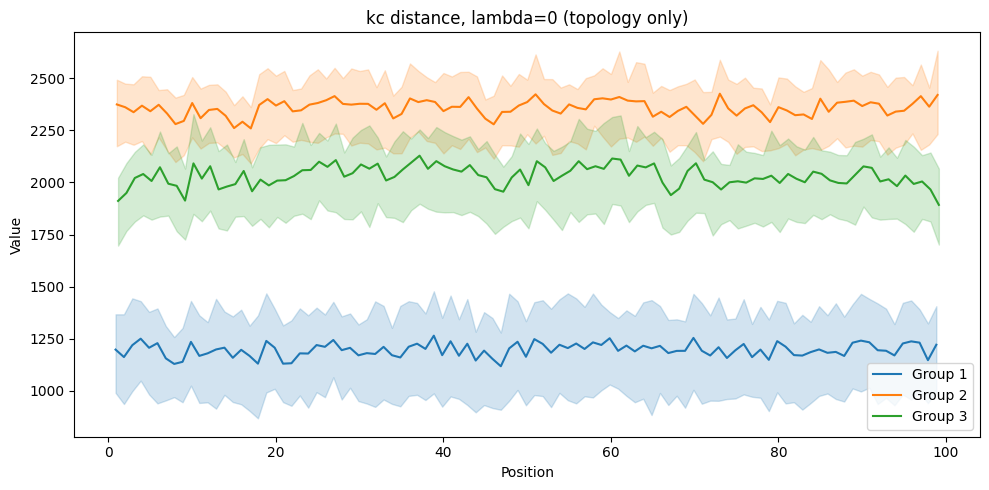

In [15]:
plot_group_quantiles(all_kc_0_groups[2],title="kc distance, lambda=0 (topology only)")

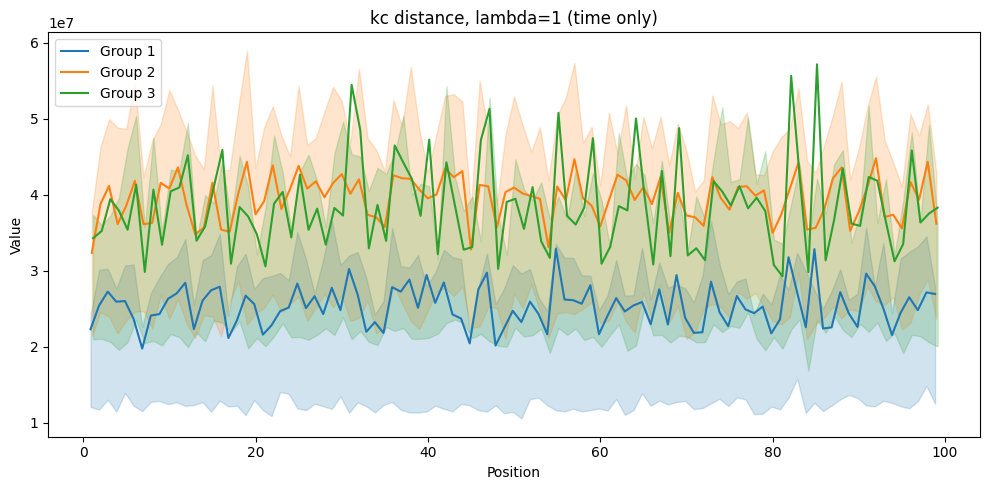

In [42]:
plot_group_quantiles(all_kc_1_groups[2],title="kc distance, lambda=1 (time only)")

In [10]:
all_rf_groups=[]
for name in small_names:
    all_rf_groups.append(get_within_between(name,func=rf_dist_ts))
    print(name,"done")

Ne2e+04_100_1e+06 done
Ne2e+04_300_1e+06 done
Ne2e+04_1000_1e+06 done


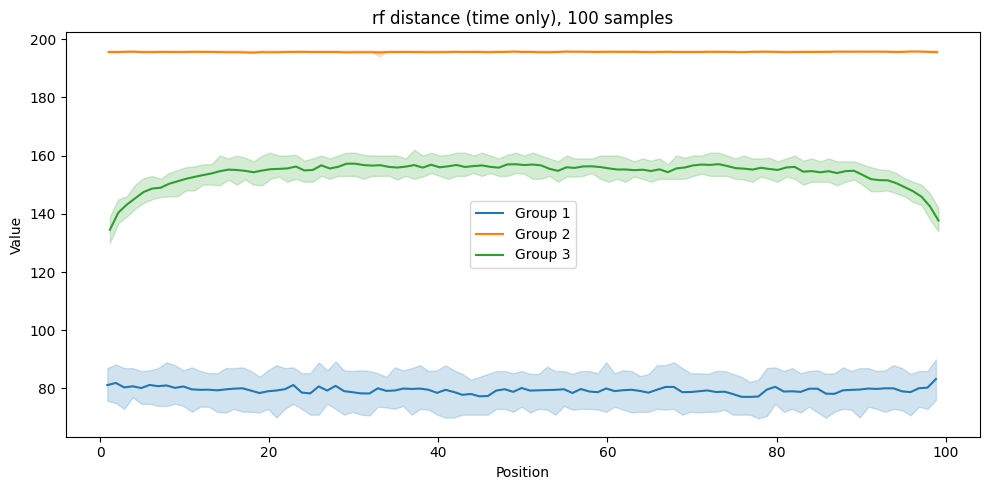

In [ ]:
plot_group_quantiles(all_rf_groups[0],title="rf distance (time only), 100 samples")

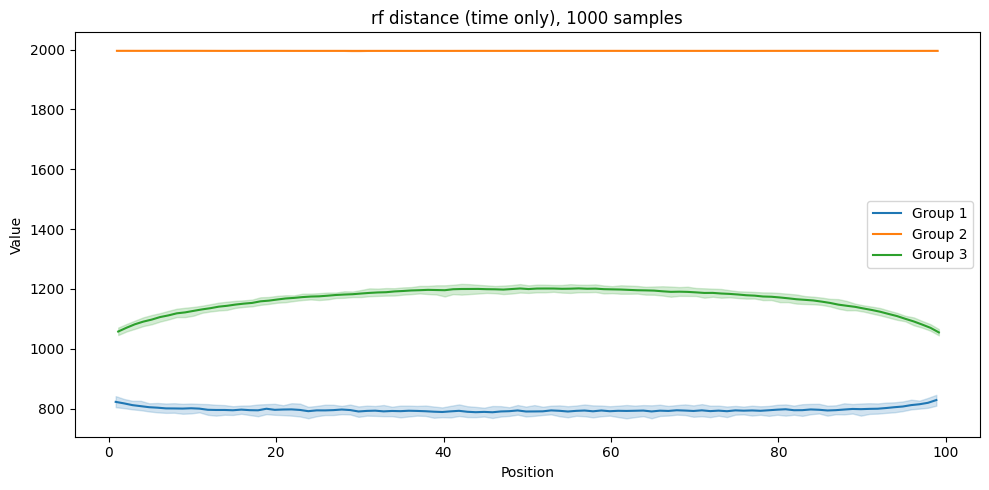

In [14]:
plot_group_quantiles(all_rf_groups[2],title="rf distance (time only), 1000 samples")

In [ ]:
#compute kc_distance between inferred and true


within_dis=[]
pos=[i for i in range(int(1e4),int(1e6),int(1e4))]
for i in range(100):
    inferred=tskit.load(f"{head}{name}/{i}/{name}_{i}-inferred.tsdate.trees")
    true=tskit.load(f"{head}{name}/{i}/{name}_{i}.trees")
    within_dis.append(kc_dist_ts(true,inferred,pos,pos))
    print(i,"done")

between_dis1=[]
between_dis2=[]
pos=[i for i in range(int(1e4),int(1e6),int(1e4))]
last_inferred=tskit.load(f"{head}{name}/{99}/{name}_{99}-inferred.tsdate.trees")
last_true=tskit.load(f"{head}{name}/{99}/{name}_{99}.trees")
for i in range(100):
    inferred=tskit.load(f"{head}{name}/{i}/{name}_{i}-inferred.tsdate.trees")
    true=tskit.load(f"{head}{name}/{i}/{name}_{i}.trees")
    between_dis1.append(kc_dist_ts(true,last_true,pos,pos))
    between_dis2.append(kc_dist_ts(inferred,last_inferred,pos,pos))
    last_inferred=inferred
    last_true=true
    print(i,"done")